In [1]:
import pandas as pd
import glob
import tensorflow as tf
from pdb import set_trace
import os

print(os.getcwd())

# Directory to save logs for TensorBoard
log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Define the path where your CSV files are located
csv_files_path = '../csv_files/*.csv'

# Uncomment this section if you need to recreate a random 1% sample
data_frames = []
for file in glob.glob(csv_files_path):
    df = pd.read_csv(file, header=None)  # Load without headers
    if df.shape[1] == 7:                 # Ensure it has exactly 7 columns
        data_frames.append(df)           # Append if structure is correct
    else:
        print(f"Skipping file {file} due to unexpected number of columns: {df.shape[1]}")

# Concatenate all valid DataFrames
all_data = pd.concat(data_frames, ignore_index=True)

# Assign column names
all_data.columns = ['x', 'y', 'z', 'p_id', 'xi1', 'xi2', 'gn']

# Drop any rows with NaN values
all_data.dropna(inplace=True)

# Randomly sample 1% of the data
sampled_data = all_data.sample(frac=0.1, random_state=42)

# Save the sample
sampled_data.to_csv('sampled_data_10_percent.csv', index=False)

# Load the pre-saved 1% sampled data
sampled_data = pd.read_csv('sampled_data_10_percent.csv')

# Split into features (x, y, z) and labels (p_id, xi1, xi2, gn)
features = sampled_data[['x', 'y', 'z']].values
labels = sampled_data[['p_id', 'xi1', 'xi2', 'gn']].values

# Convert to TensorFlow dataset with (features, labels) tuples
sampled_data = tf.data.Dataset.from_tensor_slices((features, labels))

# Define the split ratio (80% train, 20% test)
train_size = int(0.8 * len(sampled_data))
train_data = sampled_data.take(train_size)
test_data = sampled_data.skip(train_size)

# Print dataset sizes to confirm
print(f"Total data size (1% sample): {len(sampled_data)}")
print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

2024-11-02 19:12:31.475217: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 19:12:31.479599: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 19:12:31.518449: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 19:12:31.554664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 19:12:31.598955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

/home/diego2/fem/Accelerated_Contact_Detection
Total data size (1% sample): 800000
Training set size: 640000
Test set size: 160000


In [2]:
import numpy as np

# Adjust labels to match the output structure of the model (4 values per patch * 96 patches)
labels_expanded = np.zeros((len(labels), 4 * 96))

# Populate the expanded labels array for each sample
for idx, (p_id, xi1, xi2, gn) in enumerate(labels):
    # Assuming p_id is the patch index (0 to 95)
    patch_idx = int(p_id)
    labels_expanded[idx, patch_idx] = 1  # One-hot encoding for p_id
    labels_expanded[idx, 96 + patch_idx] = xi1
    labels_expanded[idx, 192 + patch_idx] = xi2
    labels_expanded[idx, 288 + patch_idx] = gn

# Update the TensorFlow dataset with expanded labels
sampled_data = tf.data.Dataset.from_tensor_slices((features, labels_expanded))

# Define the split ratio (80% train, 20% test)
train_size = int(0.8 * len(sampled_data))
train_data = sampled_data.take(train_size)
test_data = sampled_data.skip(train_size)


import tensorflow as tf

def custom_loss(y_true, y_pred):

    # Classification loss for the first 96 outputs (p_id prediction)
    p_id_true = y_true[:, :96]  # True one-hot encoded patch IDs
    p_id_pred = y_pred[:, :96]  # Predicted patch probabilities

    # Use categorical cross-entropy for patch classification
    classification_loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(p_id_true, p_id_pred, from_logits=True)
    )

    # Regression targets for xi1, xi2, and gn
    xi1_true = y_true[:, 96:192]
    xi1_pred = y_pred[:, 96:192]
    xi2_true = y_true[:, 192:288]
    xi2_pred = y_pred[:, 192:288]
    gn_true = y_true[:, 288:]
    gn_pred = y_pred[:, 288:]

    # Weighted sum product using p_id_true as a mask to select the target patch
    xi1_loss = tf.reduce_sum(p_id_true * tf.square(xi1_true - xi1_pred), axis=1)
    xi2_loss = tf.reduce_sum(p_id_true * tf.square(xi2_true - xi2_pred), axis=1)
    gn_loss = tf.reduce_sum(p_id_true * tf.square(gn_true - gn_pred), axis=1)

    # Average regression loss over the batch
    regression_loss = tf.reduce_mean(xi1_loss + xi2_loss + gn_loss)
    # Total loss: Combine classification and regression losses
    total_loss = classification_loss + regression_loss
    return total_loss




In [3]:
# Verify the shapes of features and labels
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

# Configure training and test data for batching and shuffling
batch_size = 32
train_data = train_data.batch(batch_size).shuffle(1000)
test_data = test_data.batch(batch_size)

# Display one batch to confirm
for batch_features, batch_labels in train_data.take(1):
    print("Batch features:", batch_features.numpy())
    print("Batch labels:", batch_labels.numpy())

Features shape: (800000, 3)
Labels shape: (800000, 4)
Batch features: [[ 2.90766097e+00 -1.86127695e+00 -2.21639419e+00]
 [-9.75572381e-01 -1.97358681e+00 -2.26863343e+00]
 [ 2.55696731e-01 -3.84541787e+00  1.15303708e+00]
 [-4.10110167e+00  1.22863966e-01 -2.52982966e+00]
 [ 1.96053089e+00  3.84920313e-01 -3.09661768e-01]
 [-2.06477198e+00  4.79907236e-02  1.12691745e+00]
 [ 4.65985163e+00  1.13365274e+00 -8.58173835e-01]
 [ 3.99686057e+00 -2.68488262e+00  2.12730676e-01]
 [-2.20684149e+00  9.83906251e-01  5.60129427e-02]
 [ 1.89142096e-02 -7.75614940e-01 -1.30220741e+00]
 [ 1.10811381e+00 -2.68825185e-02  2.01498461e+00]
 [ 2.67087845e+00  3.84920313e-01  2.11946310e+00]
 [-3.95903215e+00  1.13365274e+00  1.46647254e+00]
 [-1.97005897e+00  1.80751191e+00  9.17960476e-01]
 [-4.07294329e-01  3.10047071e-01  3.77369828e-03]
 [-1.78063295e+00  1.50801895e+00  1.36199405e+00]
 [-1.02292889e+00 -2.68488262e+00 -1.90295872e+00]
 [-2.39626751e+00  9.09033009e-01 -1.79848023e+00]
 [-3.0592585

2024-11-02 19:12:50.080382: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Define the model architecture
input_layer = layers.Input(shape=(3,))

# Dense layers to increase dimensionality
x = layers.Dense(128, activation='relu')(input_layer)
x = layers.Dense(512, activation='relu')(x)

# Reshape layer for 3D convolution
x = layers.Reshape((8, 8, 8, 1))(x)

# 3D convolutional layer to capture spatial dependencies
x = layers.Conv3D(96, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Flatten()(x)

# Dense layer for further feature processing
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Regularization

# Output layers with separate activations
classification_output = layers.Dense(96, activation='softmax')(x)    # Classification part with softmax
regression_output = layers.Dense(288, activation=None)(x)            # Regression part with linear activation

# Concatenate both outputs to form the final output
output = layers.Concatenate()([classification_output, regression_output])

# Create the model
model = models.Model(inputs=input_layer, outputs=output)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │     66,048 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 8,   │          0 │ dense_1[0][0]     │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 8, 8, 8,   │      2,688 │ reshape[0][0]     │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 4, 4, 4,   │          0 │ conv3d[0][0]      │
│ (MaxPooling3D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6144)      │          0 │ max_pooling3d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  1,573,120 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 96)        │     24,672 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 288)       │     74,016 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,741,056 (6.64 MB)

 Trainable params: 1,741,056 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 347s 17ms/step - loss: 4.2703 - mae: 0.4717 - val_loss: 3.7993 - val_mae: 0.5062
Epoch 2/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 362s 18ms/step - loss: 3.8502 - mae: 0.5242 - val_loss: 3.7441 - val_mae: 0.4803
Epoch 3/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 377s 19ms/step - loss: 3.8051 - mae: 0.5075 - val_loss: 3.7244 - val_mae: 0.4692
Epoch 4/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 371s 19ms/step - loss: 3.7805 - mae: 0.4957 - val_loss: 3.7134 - val_mae: 0.4540
Epoch 5/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 339s 17ms/step - loss: 3.7696 - mae: 0.4882 - val_loss: 3.7047 - val_mae: 0.4578
Epoch 6/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 245s 12ms/step - loss: 3.7615 - mae: 0.4801 - val_loss: 3.7023 - val_mae: 0.4518
Epoch 7/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 241s 12ms/step - loss: 3.7523 - mae: 0.4756 - val_loss: 3.6908 - val_mae: 0.4466
Epoch 8/100
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 241s 12ms/step - loss: 3.7473 - mae: 0.4716 - val_loss: 3.6903 - val_mae:

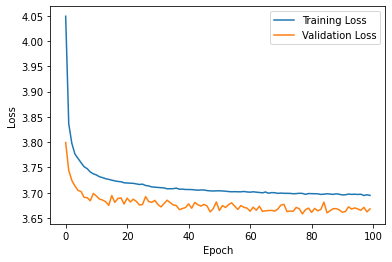

In [5]:
# Set training parameters
epochs = 100

# Train the model
history = model.fit(train_data, 
                    validation_data=test_data, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback])

# Optional: Plotting training history
import matplotlib.pyplot as plt

# Plot loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
import numpy as np

# Number of samples to display for comparison
num_samples = 10

# Take a batch from the test set
for test_features, test_labels in test_data.take(1):
    # Make predictions on the batch
    predictions = model.predict(test_features)

    # Randomly select a few samples for comparison
    indices = np.random.choice(range(len(test_features)), num_samples, replace=False)
    print("Sample Comparisons (Predicted vs True):\n")
    
    for i in indices:
        pred = predictions[i]
        true = test_labels[i].numpy()
        
        # Classification predictions (first 96 elements)
        pred_p_id = pred[:96]
        true_p_id_index = np.argmax(true[:96])  # True p_id index

        # Sort predictions to find the top 4 likely patches
        top4_indices = np.argsort(pred_p_id)[-4:][::-1]
        top4_values = pred_p_id[top4_indices]

        # Display predicted and true `p_id`
        print(f"Sample {i + 1}:")
        print("Predicted p_id ->", ', '.join([f"{idx} ({val:.2e})" for idx, val in zip(top4_indices, top4_values)]))
        print(f"True p_id      -> {true_p_id_index}")

        # Surface coordinates and gn predictions for the top 2 patches
        print("Predicted (xi1, xi2) ->", ', '.join([f"patch {idx}: ({pred[96 + idx]:.2f}, {pred[192 + idx]:.2f})" for idx in top4_indices[:2]]))
        print(f"True (xi1, xi2)      -> ({true[96 + true_p_id_index]:.2f}, {true[192 + true_p_id_index]:.2f})")

        # gn predictions for the top 2 patches
        print("Predicted gn      ->", ', '.join([f"patch {idx}: {pred[288 + idx]:.3f}" for idx in top4_indices[:2]]))
        print(f"True gn           -> {true[288 + true_p_id_index]:.3f}")
        print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Sample Comparisons (Predicted vs True):

Sample 11:
Predicted p_id -> 75 (1.00e+00), 71 (8.59e-09), 79 (1.36e-12), 55 (6.39e-15)
True p_id      -> 75
Predicted (xi1, xi2) -> patch 75: (0.58, 0.70), patch 71: (0.48, 0.93)
True (xi1, xi2)      -> (0.63, 0.75)
Predicted gn      -> patch 75: -0.384, patch 71: -0.388
True gn           -> -0.344
------------------------------
Sample 29:
Predicted p_id -> 4 (1.00e+00), 81 (6.72e-07), 67 (1.77e-15), 40 (4.95e-16)
True p_id      -> 4
Predicted (xi1, xi2) -> patch 4: (0.76, 0.07), patch 81: (0.18, 0.83)
True (xi1, xi2)      -> (0.87, 0.09)
Predicted gn      -> patch 4: -0.419, patch 81: -0.666
True gn           -> -0.508
------------------------------
Sample 28:
Predicted p_id -> 80 (1.00e+00), 16 (3.28e-14), 20 (1.01e-17), 28 (5.57e-23)
True p_id      -> 80
Predicted (xi1, xi2) -> patch 80: (0.84, 0.60), patch 16: (0.50, 0.36)
True (xi1, xi2)      -> (0.74, 0.61)
Predicted gn      -> patch 80: 1.160, patch 

2024-11-04 09:43:32.213263: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
data_frames = []
for file in glob.glob(csv_files_path):
    df = pd.read_csv(file, header=None)  # Load without headers
    if df.shape[1] == 7:                 # Ensure it has exactly 7 columns
        data_frames.append(df)           # Append if structure is correct
    else:
        print(f"Skipping file {file} due to unexpected number of columns: {df.shape[1]}")

# Concatenate all valid DataFrames
all_data = pd.concat(data_frames, ignore_index=True)

In [ ]:
all_data = pd.read_csv('sampled_data_1_percent.csv')

In [ ]:
np.array(test_features)[6]

In [ ]:
all_data.shape
all_data = np.array(all_data)
print(min(all_data[:,0]),max(all_data[:,0]))
print(min(all_data[:,1]),max(all_data[:,1]))
print(min(all_data[:,2]),max(all_data[:,2]))
print(min(all_data[:,3]),max(all_data[:,3]))
print(min(all_data[:,4]),max(all_data[:,4]))
print(min(all_data[:,5]),max(all_data[:,5]))
print(min(all_data[:,6]),max(all_data[:,6]))

In [7]:
# Save the model in the .keras format
model_name = 'CLASSIF_REGRESS_128_512_CONV3D_256_20EPOCHS'

model.save(model_name+'.keras')

import json

# Save the training history
with open(model_name+'.json', 'w') as f:
    json.dump(history.history, f)


# To later load doing:
# from tensorflow.keras.models import load_model
# model = load_model('my_model.keras')

# with open('training_history.json', 'r') as f:
#     history_data = json.load(f)